# Introduction

In this tutorial, we learn about different environments, then implement dynamic programming (model-based) algorithms and study their performance.

# Notebook setup

## Instructions

- Import numpy, scipy and matplotlib
- Configure inline plots

In [0]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

# Tutorial

In order to learn about RL algorithms, we will explore different worlds (also called environments), which are listed below. For more details about each world, please look into their implementation in module RL_worlds.

## N-armed bandit task

In an N-armed bandit task, there is only a single state. Our implementation is a 4-armed bandit, which means there are 4 available actions, and each one returns a different reward.

In [25]:
from IPython.display import Image
Image(url="https://github.com/goptavares/intro-to-rl/blob/master/4ArmedBandit.png?raw=true", width=500, height=225)


## Cheese world

In this one-dimensional grid there are 4 states and 2 possible actions: left and right. Arriving at the goal state gives you a reward of 1. Moving left from the start state (state 1 in the figure) stays in the same place, and moving anywhere from the goal state (state 4 in the figure) ends the episode.

In [0]:
from IPython.display import Image
Image(url="https://github.com/goptavares/intro-to-rl/blob/master/CheeseWorld.png?raw=true", width=600, height=180)

## Cliff world

In this 4x10 grid there are 40 states and 4 possible actions: right, up, left and down. Falling into the cliff incurs a negative reward of -100 and ends the episode; moving into any other state incurs a reward of -1; moving into the world borders stays in the same place; moving anywhere from the goal state (state G in the figure) ends the episode.

In [0]:
from IPython.display import Image
Image(url="https://github.com/goptavares/intro-to-rl/blob/master/CliffWorld.png?raw=true", width=600, height=280)

## Quentin's world

In this 10x10 grid there are 100 states and 4 possible actions: right, up, left and down. The start state is in green in the figure; moving into one of the red states incurs a reward of -1; moving into the world borders stays in the same place; moving into the goal state (yellow square in the upper right corner) gives you a reward of 1; and moving anywhere from the goal state ends the episode.

In [0]:
from IPython.display import Image
Image(url="https://github.com/goptavares/intro-to-rl/blob/master/QuentinsWorld.png?raw=true", width=300, height=300)

## Multi-room windy gridworld with cliffs

In this 12x14 grid there are 168 states and 4 possible actions: right, up, left and down. The start state is marked with an S in the figure, and there are 2 goals states marked with a G. Each goal state is inside a room (the room walls are marked with darker lines). Moving into a goal states gives you a reward of 100. Moving into a wall or outside the world borders stays in the same place. The two rooms are windy, which means the resultant next states inside the rooms are shifted; the wind direction is indicated by a blue arrow, and the wind strength (size of the shift) in each column is indicated by a number between 0 and 2. There are also two cliffs marked in gray; falling into a cliff incurs a reward of -100 and ends the episode. 

In [0]:
from IPython.display import Image
Image(url="https://github.com/goptavares/intro-to-rl/blob/master/gridworld.png?raw=true", width=451.2, height=447.2)

## Helper functions

Please familiarize yourself with the code below, as it will help your write your own code to solve the exercises.

In [27]:
# Import definitions of the environments.
!pip install RL_worlds
import RL_worlds as worlds

# Import helper functions for plotting.
from plot_util import *

ERROR: Could not find a version that satisfies the requirement RL_worlds (from versions: none)
ERROR: No matching distribution found for RL_worlds


ImportError: ignored

In [0]:
def default_params(environment):
    """
    Define the default parameters.
    Args:
        environment: an object corresponding to the environment.
    Returns:
        a dictionary containing the default parameters, where the keys
            are strings (parameter names).
    """
    params = dict()
    params['environment'] = environment
    
    params['alpha'] = 0.1  # learning rate    
    params['beta'] = 10  # inverse temperature    
    params['policy'] = 'epsilon_greedy'
    params['epsilon'] = 0.05  # epsilon-greedy policy    
    params['learning_rule'] = 'q_learning'
    params['epsilon_decay'] = 0.9
    
    if environment.name == 'windy_cliff_grid':
        params['gamma'] = 0.8  # temporal discount factor
    elif environment.name == 'n_armed_bandit':
        params['gamma'] = 0.9  # temporal discount factor
    elif environment.name == 'cliff_world':
        params['gamma'] = 1.0  # no discounting
    elif environment.name == 'cheese_world':
        params['gamma'] = 1.0  # no discounting
    elif environment.name == 'quentins_world':
        params['gamma'] = 0.9  # temporal discount factor

    return params

## Exercise 1: Policy Evaluation

1. Write the policy evaluation algorithm.

Tip: The function should take the policy to be evaluated, the default parameters and a threshold for the stopping criterium as input and return the value function.

In [0]:
def policy_evaluation(policy, params, theta=0.000001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    Args:
        policy: a matrix indexed by state and action, where each entry is a float
            corresponding to the probability of taking that action from that state.
        params: a dictionary containing the default parameters.
        theta: float; we stop evaluation once our value function change is less than
            theta for all states.
    Returns:
        the value function (vector indexed by state).
    """
    env = params['environment']
    outcomes = env.get_all_outcomes()
    
    # Start with a random (all zeros) value function
    value = np.zeros(env.n_states)

    while True:
        delta = 0
        # For each state, perform a "full backup"
        for state in range(env.n_states):
            v = 0
            # Look at the possible next actions
            for action, action_prob in enumerate(policy[state]):
                # For each action, look at the possible next states
                for prob, next_state, reward in outcomes[state, action]:
                    if next_state == None:
                        value_next = 0
                    else:
                        value_next = value[next_state]
                    # Calculate the expected value
                    v += action_prob * prob * (reward + params['gamma'] * value_next)
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(value[state] - v))
            value[state] = v
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return value

## Exercise 2: Policy Iteration

1. Write the policy iteration algorithm.

Tips: The function should take the default parameters and a threshold for the stopping criterium as input and return the optimal policy and the value function for the optimal policy; you should use the policy evaluation function written in Exercise 1.

In [0]:
def policy_iteration(params, theta=0.000001):
    """
    Iteratively evaluates and improves a policy until an optimal policy is found.
    Args:
        params: a dictionary containing the default parameters.
        theta: float, to be used in policy_evaluation; we stop evaluation once our value
            function change is less than theta for all states.
    Returns:
        the optimal policy (maxtrix indexed by state and action);
        the corresponding value function (vector indexed by state).
    """
    env = params['environment']
    outcomes = env.get_all_outcomes()
    # Start with a random policy
    policy = np.ones([env.n_states, env.n_actions]) / env.n_actions
    
    while True:
        # Evaluate the current policy
        value = policy_evaluation(policy, params, theta)

        # This will be set to false if we make any changes to the policy
        policy_stable = True
        
        # Iterate over all states
        for state in range(env.n_states):
            # The best action we would take under the current policy
            chosen_action = np.argmax(policy[state])
            
            # Find the best action by one-step lookahead
            # Ties are resolved arbitarily
            action_values = np.zeros(env.n_actions)
            for action in range(env.n_actions):
                for prob, next_state, reward in outcomes[state, action]:
                    if next_state == None:
                        value_next = 0
                    else:
                        value_next = value[next_state]
                    action_values[action] += prob * (reward + params['gamma'] * value_next)
            best_action = np.argmax(action_values)
            
            # Greedily update the policy
            if chosen_action != best_action:
                policy_stable = False
            policy[state] = np.eye(env.n_actions)[best_action]

        # If the policy is stable, we've found an optimal policy
        if policy_stable:
            break
    return policy, value

## Exercise 3: Value Iteration

One drawback to policy iteration is that each of its iterations involves policy evaluation, which may be slow due to multiple sweeps through the state set. We can make this process faster by truncating the policy evaluation step of policy iteration, stopping it after just one sweep (one backup of each state). This modified algorithm is called value iteration. You can read more about it here: http://artint.info/html/ArtInt_227.html

1. Write the value iteration algorithm.

Tips: The function should take the default parameters and a threshold for the stopping criterium as input and return the policy and corresponding value function. You can write a helper function to calculate the one-step lookahead, i.e., the value for all actions in a given state using the current estimate of the value function.

In [0]:
def one_step_lookahead(state, value, params):
    """
    Helper function to calculate the value for all actions in a given state.
    Args:
        state: int, the state to consider.
        value: the value function to use as an estimator (vector indexed by state).
        params: a dictionary containing the default parameters.
    Returns:
        a vector indexed by action containing the expected value of each action.
    """
    env = params['environment']
    outcomes = env.get_all_outcomes()
    A = np.zeros(env.n_actions)
    for action in range(env.n_actions):
        for prob, next_state, reward in outcomes[state, action]:
            if next_state == None:
                value_next = 0
            else:
                value_next = value[next_state]
            A[action] += prob * (reward + params['gamma'] * value_next)
    return A

def value_iteration(params, theta=0.000001):
    """
    Value iteration algorithm.
    Args:
        params: a dictionary containing the default parameters.
        theta: float; we stop evaluation once our value function change is less
            than theta for all states.
    Returns:
        the optimal policy (matrix indexed by state and action);
        the corresponding value function (vector indexed by state).
    """    
    env = params['environment']
    value = np.zeros(env.n_states)

    while True:
        # Stopping condition
        delta = 0
        # Update each state
        for state in range(env.n_states):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(state, value, params)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - value[state]))
            # Update the value function
            value[state] = best_action_value        
        # Check if we can stop 
        if delta < theta:
            break
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros([env.n_states, env.n_actions])
    for state in range(env.n_states):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(state, value, params)
        best_action = np.argmax(A)
        # Always take the best action
        policy[state, best_action] = 1.0

    return policy, value

## Exercise 4 

1. Write code that allows you to test the performance of policy iteration and value iteration for a selected world (try cliff world, Quentin's world or windy cliff grid). Use the functions provided in the plot_util module to:
    - Plot the action corresponding to the policy at each state;
    - Plot the value associated with each state.
2. Experiment with different parameter values:
    - Pick a range for the temporal discount factor $\gamma$ and look at how the results change.
3. Compare the results obtained using policy iteration vs. value iteration, then compare these results with those obtained for Q-learning and Sarsa in the previous tutorial. What do you notice about the differences in performance between dynamic programming and TD learning algorithms? What are some of the advantages and disadvantages of each approach?

To make sure that your algorithms have been implemented correctly, compare your results to the ones shown below.

Cliff world using policy improvement and $\gamma$=0.9:

<img src="fig/tutorial1_ex4_policyimp_actions.png",height="300",width="300",align="left">
<img src="fig/tutorial1_ex4_policyimp_maxval.png",height="300",width="300">

Quentin's world using using value iteration and $\gamma$=0.9:

<img src="fig/tutorial1_ex4_valueit_actions.png",height="300",width="300",align="left">
<img src="fig/tutorial1_ex4_valueit_maxval.png",height="300",width="300">

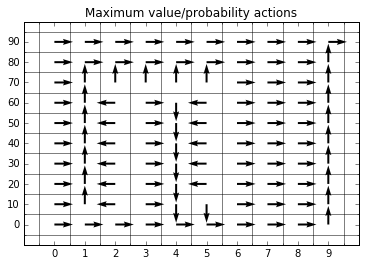

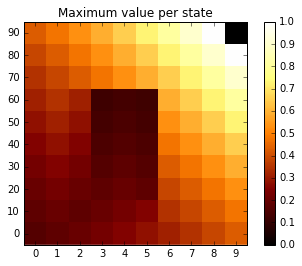

In [0]:
# Choose a world
# env = worlds.cliff_world()
env = worlds.quentins_world()
# env = worlds.windy_cliff_grid()

# Default parameters
params = default_params(environment=env)

# Decision-maker
params['gamma'] = 0.9

# Choose a DP algorithm: policy iteration or value iteration
# policy, value = policy_iteration(params)
policy, value = value_iteration(params)

fig = plot_quiver_max_action(env, policy)
fig = plot_heatmap_max_val(env, value)